In [1]:
import os
os.chdir('../') # change directory to import out modules

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

from ipywidgets import interactive
from data import config 
from data.data import Data 

In [131]:
data = Data()

LABEL_MAP = ['empty/overcrowded', 'all dead', 'all alive', '50/50']

In [132]:
def get_img_and_label(idx):
    img = np.load(f'{config.ROOT_PATH}/data/clean/img{idx}.npy')
    img = resize(img, (img.shape[0], config.IMG_SIZE[0], config.IMG_SIZE[1]), anti_aliasing=True, preserve_range=True)
    label = data[idx][1].item()
    return img, label

x_coor = np.linspace(0, config.IMG_SIZE[0], config.IMG_SIZE[1])
y_coor = np.linspace(0, config.IMG_SIZE[0], config.IMG_SIZE[1])
X_coor, Y_coor = np.meshgrid(x_coor, y_coor)

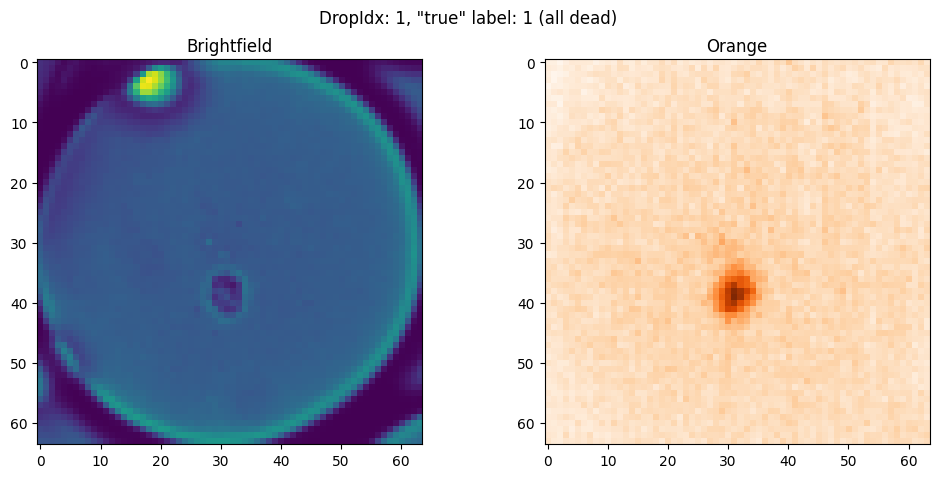

In [176]:
idx = 1
bf_channel = 3
orng_channel = 2


img, label = get_img_and_label(idx)
bf = img[bf_channel, ...]
# mirror by x-axis to check validity of the method
# bf = bf[::-1, :]
orng = img[orng_channel, ...]

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax[0].imshow(bf)
ax[0].set_title('Brightfield')
ax[1].imshow(orng, cmap='Oranges')
ax[1].set_title('Orange')
None

In [177]:
def min_max_norm(x, min=None, max=None, clip=True):
    if min is None:
        min = np.min(x)
    if max is None:
        max = np.max(x)
    x_norm = (x - min) / (max - min)
    if clip:
        x_norm = np.clip(x_norm, 0, 1)
    return x_norm

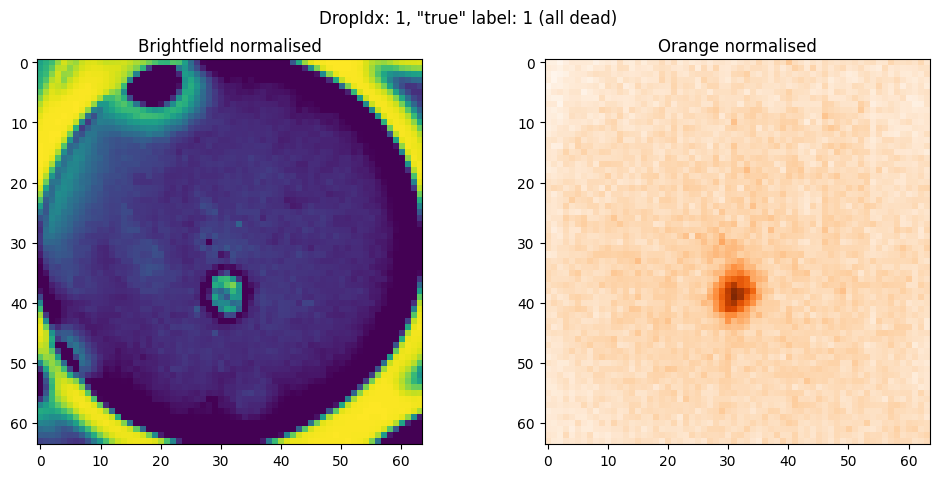

In [178]:
sample_idx = data.droplet_list[idx]['sample_idx']
norm_min = data.sample_list[sample_idx]['stats'][bf_channel]['min']
norm_max = data.sample_list[sample_idx]['stats'][bf_channel]['percentile']
bf_norm_circle = -min_max_norm(bf, norm_min, norm_max)+1 # reverse pixels
orng_norm_circle = min_max_norm(orng)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax[0].imshow(bf_norm_circle)
ax[0].set_title('Brightfield normalised')
ax[1].imshow(orng_norm_circle, cmap='Oranges')
ax[1].set_title('Orange normalised')
None

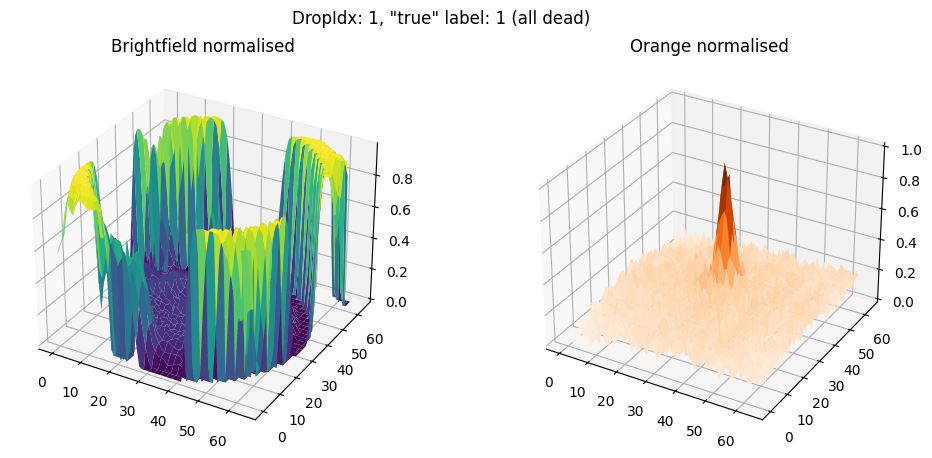

In [179]:
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax0.plot_surface(X_coor, Y_coor, bf_norm_circle, cmap='viridis')
ax0.set_title('Brightfield normalised')
ax1.plot_surface(X_coor, Y_coor, orng_norm_circle, cmap='Oranges')
ax1.set_title('Orange normalised')
None

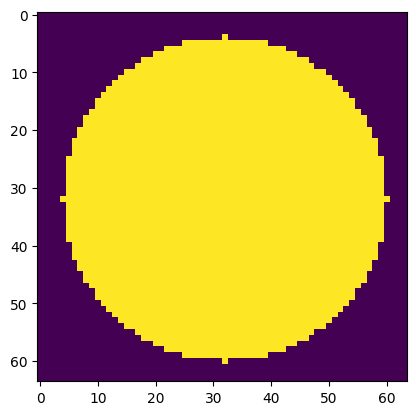

In [180]:
# look at only the 0.9*64 circle
mask = np.zeros(config.IMG_SIZE)
center = (config.IMG_SIZE[0] // 2, config.IMG_SIZE[1] // 2)
radius = int(0.9 * np.min(config.IMG_SIZE) / 2)

for i in range(config.IMG_SIZE[0]):
    for j in range(config.IMG_SIZE[1]):
        l2 = (i - center[0])**2 + (j - center[1])**2
        mask[i, j] = 1*(l2 <= radius**2)

plt.imshow(mask);

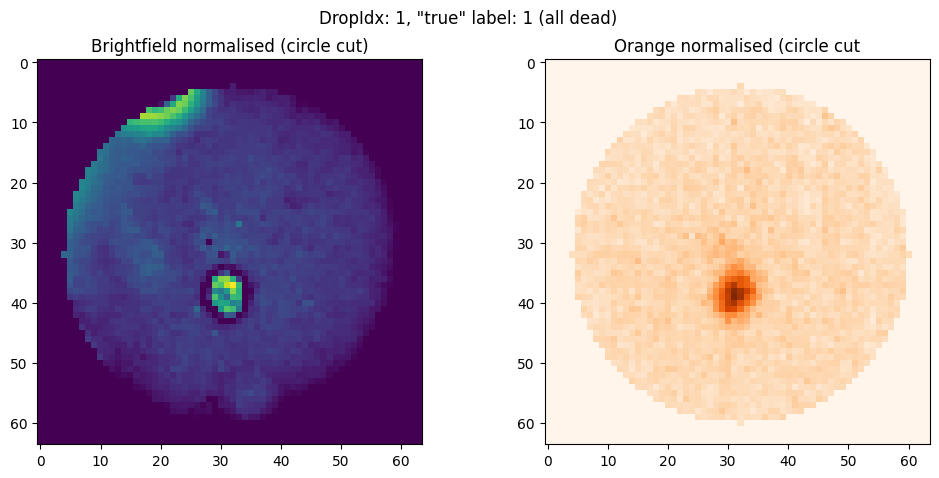

In [181]:
bf_norm_circle = bf_norm_circle * mask
orng_norm_circle = orng_norm_circle * mask

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax[0].imshow(bf_norm_circle)
ax[0].set_title('Brightfield normalised (circle cut)')
ax[1].imshow(orng_norm_circle, cmap='Oranges')
ax[1].set_title('Orange normalised (circle cut')
None

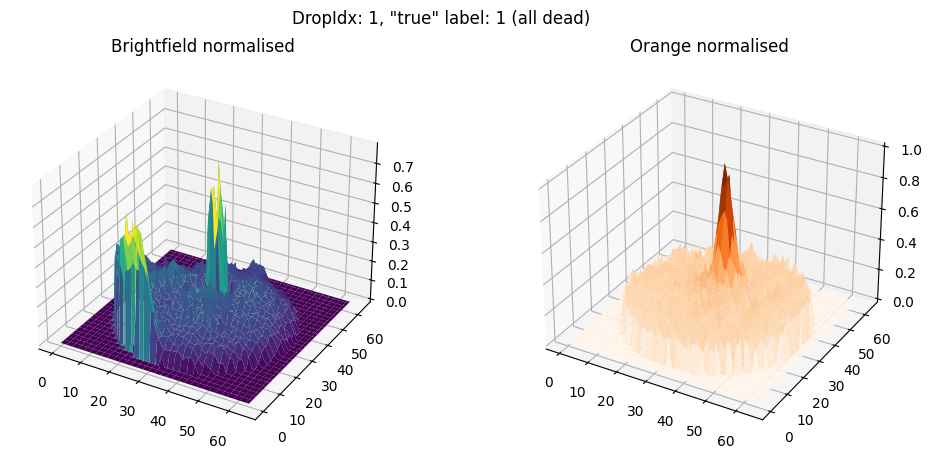

In [182]:
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax0.plot_surface(X_coor, Y_coor, bf_norm_circle, cmap='viridis')
ax0.set_title('Brightfield normalised')
ax1.plot_surface(X_coor, Y_coor, orng_norm_circle, cmap='Oranges')
ax1.set_title('Orange normalised')
None

In [183]:
h = np.minimum(orng_norm_circle, bf_norm_circle)
alpha = 0.3
h_a = 1*(h>=alpha)

bf_norm_a = 1*(bf_norm_circle >= alpha)

np.sum(h_a) / np.sum(bf_norm_a)

0.24545454545454545

In [148]:
def interactive_cut(val, axis, alpha):
    global bf_norm_circle, orng_norm_circle

    xx = np.arange(64)
    if axis == 0:
        f = bf_norm_circle[val, :]
        g = orng_norm_circle[val, :]
    elif axis == 1:
        f = bf_norm_circle[:, val]
        g = orng_norm_circle[:, val]

    plt.bar(xx, f, color='blue', label='BF Norm', alpha=0.6)
    plt.bar(xx, g, color='orange', label='Orange', alpha=0.6)
    h = np.minimum(f, g)
    plt.plot(xx, h, color='red', label='h function', alpha=0.6)
    h_a = h >= alpha
    plt.axhline(alpha, color='black', label=f'alpha = {alpha}', alpha=0.6)
    plt.scatter(xx[h_a], h[h_a], color='green', label='h_a superlevel', alpha=0.6)
    plt.legend()
    plt.show()

In [149]:
interactive_plot = interactive(interactive_cut, val=(0, 63, 1), axis=[0,1], alpha=(0, 1, 0.05))
interactive_plot

interactive(children=(IntSlider(value=31, description='val', max=63), Dropdown(description='axis', options=(0,…